# Compute spin-spin correlation function from TWORDM

In [1]:
import numpy as np

k = 20
n = 30
s = 0

## twordm for Fe2S2

In [2]:
import rdmutils

frdm = 'fe2s2/rdm2mps.0.0.txt'
#frdm = 'fe2s2/scratch/rdm2mps.0.0.txt'

twordm_spatial = rdmutils.get_twordm_spatialorbital_tensor(k,frdm)

In [3]:
np.einsum('ijji->',twordm_spatial)

870.0

In [4]:
n*(n-1)

870

In [5]:
twordm_spinorb = rdmutils.get_twordm_spinorbital_tensor(k,frdm)
onerdm_spinorb = np.einsum('pjjq->pq',twordm_spinorb)/(n-1)

## rotate twordm to the original basis

In [6]:
import oodmrg_util

urot = oodmrg_util.loadUrot("fe2s2/urot.txt",k)

In [7]:
twordm_spatial_lmo = rdmutils.twordm_backtransform(twordm_spatial,urot)

In [8]:
np.einsum('ijji->',twordm_spatial_lmo)

869.9999999997642

In [9]:
onerdm_spatial_lmo = np.einsum('pjjq->pq',twordm_spatial_lmo)/(n-1)

In [10]:
np.sum(np.diag(onerdm_spatial_lmo))

29.999999999991868

In [11]:
import spinTools

szpdm = spinTools.szHS(onerdm_spatial_lmo,twordm_spatial_lmo,n,s)

In [12]:
np.linalg.norm(szpdm),np.trace(szpdm)

(4.140358696805941e-12, -8.881784197001252e-16)

In [86]:
# pdm1a = (onerdm_spatial_lmo + 2*szpdm)/2
# pdm1b = (onerdm_spatial_lmo - 2*szpdm)/2
pdm1a = np.einsum('ij,pi,qj->pq',onerdm_spinorb[::2,::2],urot,urot)
pdm1b = np.einsum('ij,pi,qj->pq',onerdm_spinorb[1::2,1::2],urot,urot)
delta = np.identity(k)
hdm1a = delta - pdm1a
hdm1b = delta - pdm1b

In [87]:
np.trace(pdm1a),np.trace(pdm1b)

(14.999999999997968, 14.999999999997968)

In [88]:
np.trace(pdm1a) + np.trace(pdm1b)

29.999999999995936

In [89]:
np.linalg.norm(onerdm_spatial_lmo - pdm1a - pdm1b)

9.720770889448898e-13

In [90]:
np.trace(hdm1a),np.trace(hdm1b)

(5.000000000002031, 5.000000000002031)

### Check idempotency: for a single Slater determinant, this should be zero.

In [91]:
np.linalg.norm(pdm1a.dot(pdm1a) - pdm1a),\
np.linalg.norm(pdm1b.dot(pdm1b) - pdm1b)

(0.7905694150420949, 0.7905694150420949)

In [92]:
twordm_mf_lmo = np.einsum('ps,qr->pqrs',onerdm_spatial_lmo,onerdm_spatial_lmo) \
              - np.einsum('pr,qs->pqrs',pdm1a,pdm1a) \
              - np.einsum('pr,qs->pqrs',pdm1b,pdm1b)
diff = twordm_spatial_lmo - twordm_mf_lmo

In [93]:
np.linalg.norm(diff)

6.082762530297933

## spin-spin correlation funciton

In [94]:
groups = [[2,3,4,5,6],[13,14,15,16,17]]

In [95]:
import spinAnalyzer

sisj = spinAnalyzer.spinAnalyzer(twordm_spatial_lmo,groups,k,n,s)


[spinAnalyzer]: k,n,s= 20 30 0
<n>= 29.999999999991868
<s2>= 1.0658141036401503e-14
igroup= 0 s2exp= 7.473148414752378 seff= 2.2790553097684794
igroup= 1 s2exp= 7.294076687418777 seff= 2.246648264233842
s2sum= 0.6663634577823885
[[ 7.47314841 -7.05043082]
 [-7.05043082  7.29407669]]
tr(Sz)= -8.881784197001252e-16
sz= [-2.68229883e-13  3.93463040e-13] 1.2523315717771766e-13
ne= [5.47476467 5.54403921] 11.018803878706343


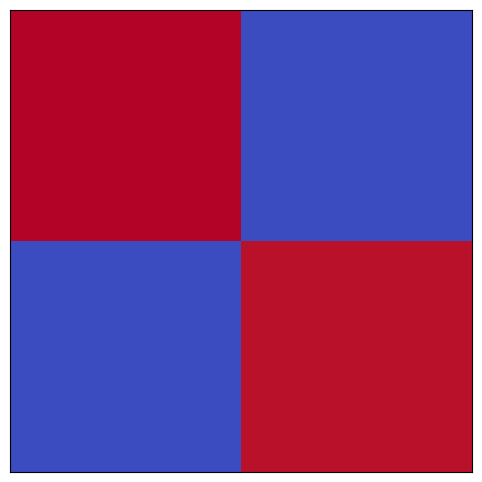

saved to fname= fe2s2/fe2s2.pdf


0

In [96]:
spinAnalyzer.genSpinSpinPlot(sisj,'fe2s2/fe2s2.pdf')

In [97]:
print(sisj)

[[ 7.47314841 -7.05043082]
 [-7.05043082  7.29407669]]


## mean-field contribution

In [98]:
ng = len(groups)

# <Si*Sj>
sisj_mf = np.zeros((ng,ng))
for i,ig in enumerate(groups):
    for j,jg in enumerate(groups):

        pdm1a_pp = np.diag(pdm1a[np.ix_(ig,ig)].diagonal())
        pdm1b_pp = np.diag(pdm1b[np.ix_(ig,ig)].diagonal())
        pdm1a_qq = np.diag(pdm1a[np.ix_(jg,jg)].diagonal())
        pdm1b_qq = np.diag(pdm1b[np.ix_(jg,jg)].diagonal())
        pdm1a_pq = pdm1a[np.ix_(ig,jg)]
        pdm1b_pq = pdm1b[np.ix_(ig,jg)]
        hdm1a_pq = hdm1a[np.ix_(ig,jg)]
        hdm1b_pq = hdm1b[np.ix_(ig,jg)]

        sisj_mf[i,j] =   0.5*np.einsum('pq,pq',pdm1b_pq,hdm1a_pq) \
                      +  0.5*np.einsum('pq,pq',pdm1a_pq,hdm1b_pq) \
                      - 0.25*np.einsum('pp,qq',pdm1a_pp,pdm1b_qq) \
                      - 0.25*np.einsum('pp,qq',pdm1b_pp,pdm1a_qq) \
                      + 0.25*np.einsum('pp,qq',pdm1a_pp,pdm1a_qq) \
                      + 0.25*np.einsum('pp,qq',pdm1b_pp,pdm1b_qq) \
                      + 0.25*np.einsum('pq,pq',pdm1a_pq,hdm1a_pq) \
                      + 0.25*np.einsum('pq,pq',pdm1b_pq,hdm1b_pq)

sisj_mf

array([[ 1.84986494, -0.0019221 ],
       [-0.0019221 ,  1.83773775]])

## difference

In [99]:
sisj - sisj_mf

array([[ 5.62328348, -7.04850873],
       [-7.04850873,  5.45633894]])

# Check MPS

In [2]:
import ctns_loader

ctns = ctns_loader.ctns_info()

ctns.load('fe2s2/rcanon_conf_su2_nonsu2.bin')

sites = ctns.toMPSdense()

In [19]:
import numpy as np
import mps_simple

shapes = mps_simple.shapes(sites)
print('shapes=\n',shapes)

shapes=
 [(1, 4, 1), (1, 4, 1), (1, 4, 2), (2, 4, 3), (3, 4, 3), (3, 4, 3), (3, 4, 4), (4, 4, 5), (5, 4, 6), (6, 4, 6), (6, 4, 6), (6, 4, 5), (5, 4, 4), (4, 4, 4), (4, 4, 3), (3, 4, 3), (3, 4, 2), (2, 4, 1), (1, 4, 4), (4, 4, 1)]


In [20]:
ova = mps_simple.overlap(sites,sites)
ova

array([[1.]])

In [21]:
mps_simple.checkRCF(sites)

check i= 19  site.shape= (4, 4, 1)  |S-I|= 6.280369834735101e-16
check i= 18  site.shape= (1, 4, 4)  |S-I|= 0.0
check i= 17  site.shape= (2, 4, 1)  |S-I|= 6.280369834735101e-16
check i= 16  site.shape= (3, 4, 2)  |S-I|= 3.8459253727671276e-16
check i= 15  site.shape= (3, 4, 3)  |S-I|= 3.8459253727671276e-16
check i= 14  site.shape= (4, 4, 3)  |S-I|= 3.1401849173675503e-16
check i= 13  site.shape= (4, 4, 4)  |S-I|= 3.1401849173675503e-16
check i= 12  site.shape= (5, 4, 4)  |S-I|= 6.661338147750939e-16
check i= 11  site.shape= (6, 4, 5)  |S-I|= 5.438959822042073e-16
check i= 10  site.shape= (6, 4, 6)  |S-I|= 9.42055475210265e-16
check i= 9  site.shape= (6, 4, 6)  |S-I|= 9.42055475210265e-16
check i= 8  site.shape= (5, 4, 6)  |S-I|= 1.0235750533041806e-15
check i= 7  site.shape= (4, 4, 5)  |S-I|= 8.881784197001252e-16
check i= 6  site.shape= (3, 4, 4)  |S-I|= 1.1644117316690922e-15
check i= 5  site.shape= (3, 4, 3)  |S-I|= 3.8459253727671276e-16
check i= 4  site.shape= (3, 4, 3)  |S-I|= 3

0

19.632393120372473 [0.0, -4.440892098500627e-16, 0.6931471805599452, 1.0986122886681096, 1.0986122886681096, 1.0986122886681096, 1.3862943611198901, 1.6094379124340996, 1.7917594692280532, 1.7917594692280532, 1.7917594692280532, 1.6094379124340987, 1.3862943611198895, 1.3862943611198895, 1.0986122886681093, 1.0986122886681093, 0.6931471805599461, 2.4424906541753416e-15, 1.9984014443252798e-15]


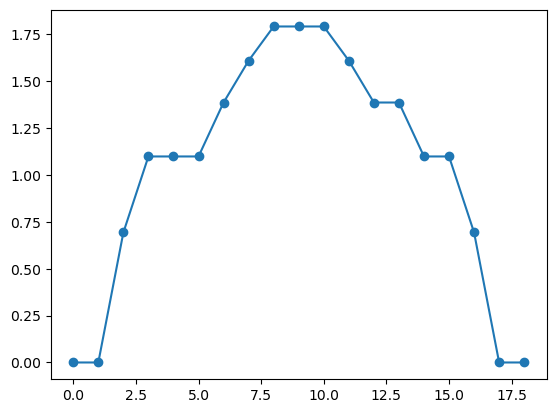

In [22]:
iroot = 0
svn = mps_simple.bipartiteEntropy(sites,iroot)
print(np.sum(svn),svn)

import matplotlib.pyplot as plt

plt.plot(svn,'o-')

In [23]:
spMPS = mps_simple.singleSiteEntropy(sites,iroot)
print('spMPS=\n',np.sum(spMPS),spMPS)

spMPS=
 6.931471805599465 [ 0.00000000e+00  0.00000000e+00  6.93147181e-01  6.93147181e-01
 -2.22044605e-16  0.00000000e+00  6.93147181e-01  6.93147181e-01
  6.93147181e-01  1.11022302e-15  1.55431223e-15  6.93147181e-01
  6.93147181e-01  1.44328993e-15  6.93147181e-01  1.55431223e-15
  6.93147181e-01  6.93147181e-01  1.44328993e-15  1.44328993e-15]


In [24]:
spqMPS = mps_simple.twoSiteEntropy(sites,iroot)
print('spqMPS=\n',spqMPS)

spqMPS=
 [[ 0.00000000e+00  0.00000000e+00  6.93147181e-01  6.93147181e-01
  -2.22044605e-16  0.00000000e+00  6.93147181e-01  6.93147181e-01
   6.93147181e-01  1.11022302e-15  1.55431223e-15  6.93147181e-01
   6.93147181e-01  1.44328993e-15  6.93147181e-01  1.55431223e-15
   6.93147181e-01  6.93147181e-01  1.44328993e-15  1.44328993e-15]
 [ 0.00000000e+00  0.00000000e+00  6.93147181e-01  6.93147181e-01
  -2.22044605e-16  0.00000000e+00  6.93147181e-01  6.93147181e-01
   6.93147181e-01  1.11022302e-15  1.55431223e-15  6.93147181e-01
   6.93147181e-01  1.44328993e-15  6.93147181e-01  1.55431223e-15
   6.93147181e-01  6.93147181e-01  1.44328993e-15  1.44328993e-15]
 [ 6.93147181e-01  6.93147181e-01  0.00000000e+00  1.09861229e+00
   6.93147181e-01  6.93147181e-01  1.09861229e+00  1.09861229e+00
   1.09861229e+00  6.93147181e-01  6.93147181e-01  1.11245658e+00
   1.11245658e+00  6.93147181e-01  1.11245658e+00  6.93147181e-01
   1.11245658e+00  1.11245658e+00  6.93147181e-01  6.93147181e-01

In [25]:
IpqMPS = mps_simple.mutualInformation(spqMPS,spMPS)
print('IpqMPS=\n',IpqMPS)

IpqMPS=
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.87682072e-01
  -2.22044605e-16 -1.11022302e-16  2.87682072e-01  2.87682072e-01
   2.87682072e-01  5.55111512e-16  8.88178420e-16  2.73837779e-01
   2.73837779e-01  7.77156117e-16  2.73837779e-01  8.88178420e-16
   2.73837779e-01  2.73837779e-01  7.77156117e-16  7.77156117e-16

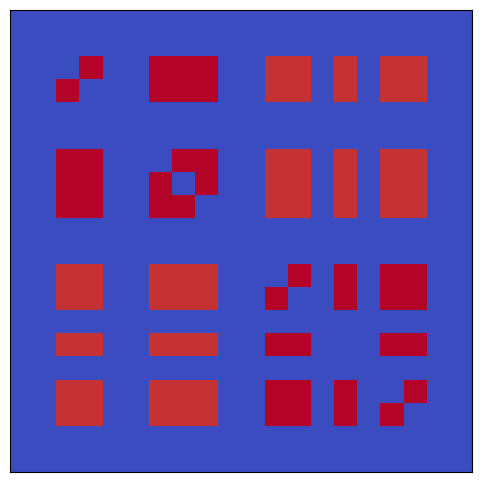

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm

ischeme = 'nearest'
fig, axes = plt.subplots(1, 1, figsize=(12, 6),
             subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
clmap = cm.coolwarm
im = axes.imshow(IpqMPS,interpolation=ischeme,cmap=clmap)
plt.show()

# Convert from abab to aabb

In [3]:
import mps_simple

mps_simple.shapes(sites)

[(1, 4, 1),
 (1, 4, 1),
 (1, 4, 2),
 (2, 4, 3),
 (3, 4, 3),
 (3, 4, 3),
 (3, 4, 4),
 (4, 4, 5),
 (5, 4, 6),
 (6, 4, 6),
 (6, 4, 6),
 (6, 4, 5),
 (5, 4, 4),
 (4, 4, 4),
 (4, 4, 3),
 (3, 4, 3),
 (3, 4, 2),
 (2, 4, 1),
 (1, 4, 4),
 (4, 4, 1)]

In [4]:
sites_new = mps_simple.to_abab(sites)

In [5]:
mps_simple.shapes(sites_new)

[(1, 2, 1),
 (1, 2, 1),
 (1, 2, 1),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 2),
 (2, 2, 4),
 (4, 2, 3),
 (3, 2, 3),
 (3, 2, 3),
 (3, 2, 3),
 (3, 2, 3),
 (3, 2, 6),
 (6, 2, 4),
 (4, 2, 8),
 (8, 2, 5),
 (5, 2, 10),
 (10, 2, 6),
 (6, 2, 6),
 (6, 2, 6),
 (6, 2, 6),
 (6, 2, 6),
 (6, 2, 10),
 (10, 2, 5),
 (5, 2, 8),
 (8, 2, 4),
 (4, 2, 4),
 (4, 2, 4),
 (4, 2, 6),
 (6, 2, 3),
 (3, 2, 3),
 (3, 2, 3),
 (3, 2, 4),
 (4, 2, 2),
 (2, 2, 2),
 (2, 2, 1),
 (1, 2, 1),
 (1, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

In [6]:
mps_simple.checkRCF(sites_new)

check i= 39  site.shape= (2, 2, 1)  |S-I|= 0.0
check i= 38  site.shape= (4, 2, 2)  |S-I|= 9.155133597044475e-16
check i= 37  site.shape= (1, 2, 4)  |S-I|= 0.0
check i= 36  site.shape= (1, 2, 1)  |S-I|= 0.0
check i= 35  site.shape= (2, 2, 1)  |S-I|= 0.0
check i= 34  site.shape= (2, 2, 2)  |S-I|= 6.280369834735101e-16
check i= 33  site.shape= (4, 2, 2)  |S-I|= 0.0
check i= 32  site.shape= (3, 2, 4)  |S-I|= 3.8459253727671276e-16
check i= 31  site.shape= (3, 2, 3)  |S-I|= 0.0
check i= 30  site.shape= (3, 2, 3)  |S-I|= 3.8459253727671276e-16
check i= 29  site.shape= (6, 2, 3)  |S-I|= 0.0
check i= 28  site.shape= (4, 2, 6)  |S-I|= 3.1401849173675503e-16
check i= 27  site.shape= (4, 2, 4)  |S-I|= 0.0
check i= 26  site.shape= (4, 2, 4)  |S-I|= 3.1401849173675503e-16
check i= 25  site.shape= (8, 2, 4)  |S-I|= 0.0
check i= 24  site.shape= (5, 2, 8)  |S-I|= 6.661338147750939e-16
check i= 23  site.shape= (10, 2, 5)  |S-I|= 0.0
check i= 22  site.shape= (6, 2, 10)  |S-I|= 5.438959822042073e-16
chec

0